In [1]:
import numpy as np
import pdb
from env.ofdm_env import ISAC_BS
from PPO import Agent
from copy import deepcopy
import torch
import random
import pickle

/home/dhy/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(777)
random.seed(777)
torch.manual_seed(777)

In [3]:
env = ISAC_BS(N=8,N_c=6,N_r=4)
# Power Configurations
rewards = []
SUM_R_P_s=[]
SUM_C_P_s=[]
SUM_R_c_s=[]
SUM_MI_r_s=[]
EE_C_s=[]
EE_R_s=[]
#
record_U = []
record_D = []

# 

In [93]:
next_state,reward,done,EE_C,EE_R,bl_random_reward,bl_random_EE_C,bl_random_EE_R=env.step(np.array([4,4,4,4,4,4,0,0]))
print(reward)
print(bl_random_reward)
t=np.argsort(next_state[env.N_r:])[:env.N_r]
print(next_state[env.N_r:])
print(np.sort(t))

-5.0
4.341447043143977
[6.56896333e-07 9.30764549e-08 2.59711886e-05 6.38883876e-07
 1.48711908e-07 1.83482258e-07 0.00000000e+00 0.00000000e+00]
[1 4 6 7]


In [90]:
env.D[:,np.sort(t)] = np.eye(4)[:,np.array([1,1,2,3])]

In [91]:
bb=np.zeros(8)
bb[t]=1.0
env.D

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [23]:
env._penalty_lt()
np.any(env.select_num < (env.time+1)*0.5)
np.any(np.sum(env.D, axis=0) > 1.5)
(env.time+1)*0.5
env.select_num

array([4., 6., 4., 2.])

In [23]:
model = Agent(state_dim = 24, action_dim = 8, cate_dim = 8).to(torch.device("cuda:0"))
model.load_state_dict(torch.load("/home/dhy/final/ISAC_OFDM/models/PPO_TD_2023-04-25-15-17-57/update_150.mo"))

<All keys matched successfully>

In [24]:
next_state,done = env.reset()
next_obs = torch.Tensor(next_state).to(torch.device("cuda:0"))
action, logprob, _, value = model.get_action_and_value(x=next_obs)
action

tensor([5, 5, 5, 5, 5, 5, 5, 6], device='cuda:0')

In [25]:
reward_model = []
action_model = []
next_state,done = env.reset()
next_obs = torch.Tensor(next_state).to(torch.device("cuda:0"))
for i in range(40000):
    action, logprob, _, value = model.get_action_and_value(x=next_obs)
    next_obs, reward, done, bl_reward = env.step(action.cpu().numpy())
    next_obs = torch.Tensor(next_obs).to(torch.device("cuda:0"))
    reward_model.append(reward)
    action_model.append(action)
f = open(f"./figure/new_reward_{env.N}{env.N_c}{env.N_r}.pkl","wb")
pickle.dump(reward_model,f)
f.close()

In [6]:
from itertools import permutations
full_set_u = list(permutations(list(range(8)),6))
print(len(full_set_u))
full_set_d = list(permutations(list(range(8)),4))
print(len(full_set_d))

20160
1680


In [ ]:
optimal_u = None
optimal_d = None
max_value = 0.0
for u in full_set_u:
    for d in full_set_d:
        _SET = np.eye(env.N)
        env.U = _SET[u,:]
        env.D = _SET[d,:]
        SUM_R_P,SUM_C_P,SUM_R_c,SUM_MI_r,EE_C,EE_R = env.get_performance()
        value = (EE_C/(5*1e4)+EE_R/10.0)
        if value > max_value:
            max_value = value
            optimal_u = u
            optimal_d = d

In [7]:
reward_naive = []
reward_rand = []
for i in range(40000):
    env._naive_allocation()
    SUM_R_P,SUM_C_P,SUM_R_c,SUM_MI_r,EE_C,EE_R = env.get_performance()
    reward = env.reward_to_go(EE_C,EE_R)
    reward_naive.append(reward)
    env._random_allocation()
    SUM_R_P,SUM_C_P,SUM_R_c,SUM_MI_r,EE_C,EE_R = env.get_performance()
    reward = env.reward_to_go(EE_C,EE_R)
    reward_rand.append(reward)
    _ = env.step(freeze=False)
print(max(reward_naive))
print(max(reward_rand))

32.596123333291736
9.531032577159205


In [8]:
print(np.mean(reward_naive))
print(np.mean(reward_rand))
print(np.mean(reward_model))

23.763193744763345
1.8180809938178562
23.43833034865069


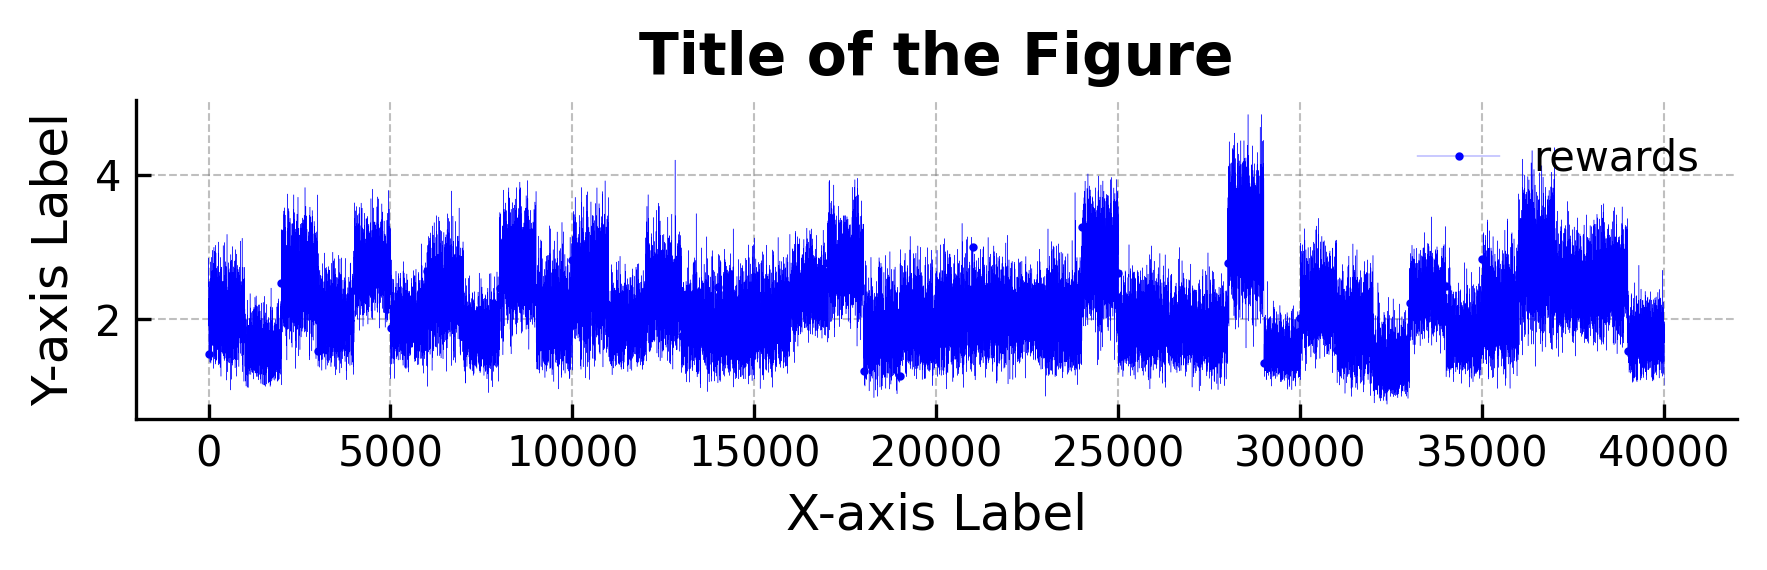

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
x = np.linspace(0, 40000, 40000)
# y1 = np.array(rewards) 
y1 = np.array(SUM_R_c_s)/np.array(SUM_C_P_s)/(5*1e4) + np.array(SUM_MI_r_s)/np.array(SUM_R_P_s)/10.0
y2 = np.array(SUM_R_P_s)
y3 = np.array(SUM_C_P_s)
y4 = np.array(SUM_R_c_s)/np.array(SUM_C_P_s)/(5*1e4)
y5 = np.array(SUM_MI_r_s)/np.array(SUM_R_P_s)/10.0
# y4 = np.array(EE_C_s)
# y5 = np.array(EE_R_s)
y6 = np.array(SUM_R_c_s)
y7 = np.array(SUM_MI_r_s)

# Create figure
fig, ax = plt.subplots(figsize=(6, 2), dpi=300)

# Set plot style with line and markers
ax.plot(x, y1, label='rewards', color='b', linewidth=0.1, marker='o', markersize=1, linestyle='-', markevery=1000)
# ax.plot(x, y2, label='SUM_R_P_s', color='r', linewidth=0.1, marker='<', markersize=1, linestyle='-', markevery=1000)
# ax.plot(x, y3, label='SUM_C_P_s', color='g', linewidth=0.1, marker='>', markersize=1, linestyle='-', markevery=1000)
# ax.plot(x, y4, label='EE_C_s', color='c', linewidth=0.1, marker='.', markersize=1, linestyle='-', markevery=1000)
# ax.plot(x, y5, label='EE_R_s', color='m', linewidth=0.1, marker='*', markersize=1, linestyle='-', markevery=1000)
# ax.plot(x, y6, label='SUM_R_c_s', color='g', linewidth=0.1, marker='*', markersize=1, linestyle='-', markevery=1000)
# ax.plot(x, y7, label='SUM_MI_r_s', color='m', linewidth=0.1, marker='*', markersize=1, linestyle='-', markevery=1000)

# Set axis labels
ax.set_xlabel('X-axis Label', fontsize=12)
ax.set_ylabel('Y-axis Label', fontsize=12)

# Set title
ax.set_title('Title of the Figure', fontsize=14, fontweight='bold')

# Set legend
ax.legend(loc='upper right', fontsize=10, frameon=False)

# Set tick parameters
ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set grid
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Set figure layout
fig.tight_layout()


# Show figure
plt.show()


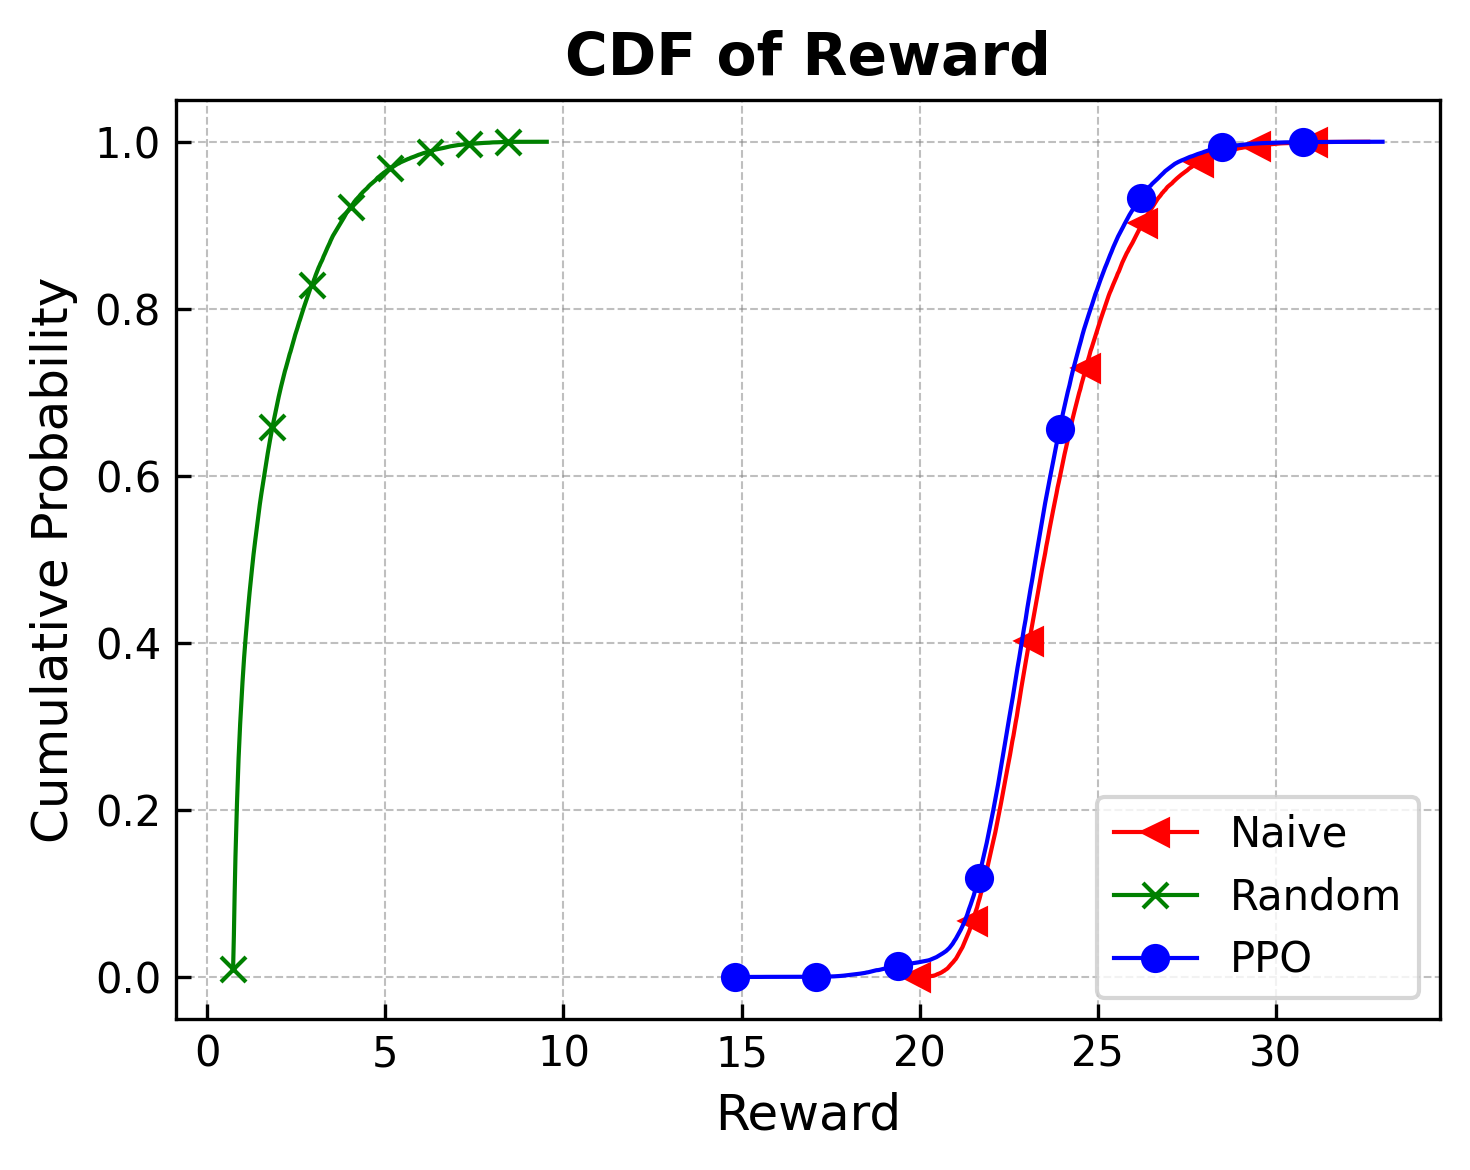

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
x = np.linspace(0, 40000, 40000)
y1 = np.array(reward_naive) 
y2= np.array(reward_rand) 
y3= np.array(reward_model) 


# cal cdf
def cal_cdf(y_in):
    hist, bin_edges = np.histogram(y_in,bins=400,density=True)
    y_cdf = np.cumsum(hist/np.sum(hist))
    return bin_edges[1:],y_cdf
    # return bin_edges[1:],hist/np.sum(hist)

bin1,y1_cdf = cal_cdf(y1)
bin2,y2_cdf = cal_cdf(y2)
bin3,y3_cdf = cal_cdf(y3)
# Create figure
plt.figure(figsize=(5, 4), dpi=300)
plt.plot(bin1,y1_cdf,label='Naive',color='r', marker='<',linewidth=1, markevery=50)
plt.plot(bin2,y2_cdf,label='Random',color='g', marker='x',linewidth=1, markevery=50)
plt.plot(bin3,y3_cdf,label='PPO',color='b', marker='o',linewidth=1, markevery=50)

# ax.plot(y1,label='Naive',color='r', linewidth=0.5)
# ax.plot(y2,label='Random',color='g', linewidth=0.5)
# ax.plot(y3,label='PPO',color='b', linewidth=0.5)

# Set axis labels
plt.xlabel('Reward', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)

# Set title
plt.title('CDF of Reward', fontsize=14, fontweight='bold')

# Set legend
plt.legend(loc='lower right', fontsize=10, frameon=True)

# Set tick parameters
plt.tick_params(axis='both', which='both', direction='in', labelsize=10)
# plt.spines['top'].set_visible(False)
# plt.spines['right'].set_visible(False)

# Set grid
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Set figure layout
plt.tight_layout()

# Show figure
plt.show()


In [13]:
env = ISAC_BS(N=8,N_c=8,N_r=2)
env._get_state().shape

(144,)

In [ ]:
a = np.eye([8])
b = np.array([1,2,3,1,2,3,1,2,3])